# Recommendation System

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  

In [3]:
# Load the data
df = pd.read_csv('D:/Recovery Data/Data Science Projects/Recommendation System/Data/ratings_Beauty.csv')

### Basic Exploratory Data Analysis (EDA)

In [4]:
print("Shape: %s" % str(df.shape))
print("Column name: %s" % str(df.columns))

Shape: (2023070, 4)
Column name: Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')


In [5]:
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [6]:
# Unique Users and Products
print("Unique UserID count: %s" % str(df.UserId.nunique()))
print("Unique ProductID count: %s" % str(df.ProductId.nunique()))

Unique UserID count: 1210271
Unique ProductID count: 249274


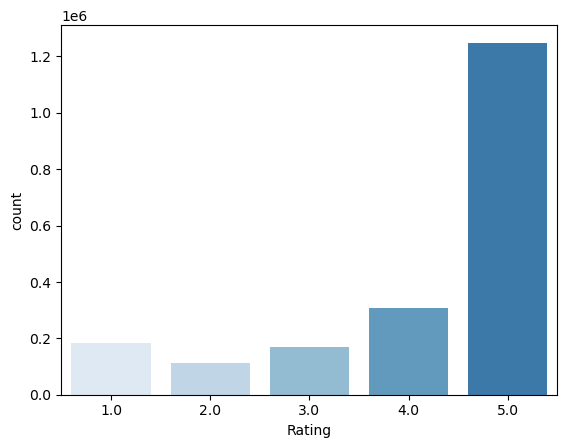

In [7]:
# Rating frequency
sns.countplot(data=df, x='Rating', palette=sns.color_palette('Blues'))
plt.show()

#### Data Wrangling
- Creating fields and measures from existing data
- This helps generate more data points and validates the ideology

In [8]:
# Mean rating for each product
product_rating = df.groupby('ProductId')['Rating'].mean()

In [9]:
product_rating.head()

ProductId
0205616461    5.0
0558925278    4.0
0733001998    4.0
0737104473    1.0
0762451459    5.0
Name: Rating, dtype: float64

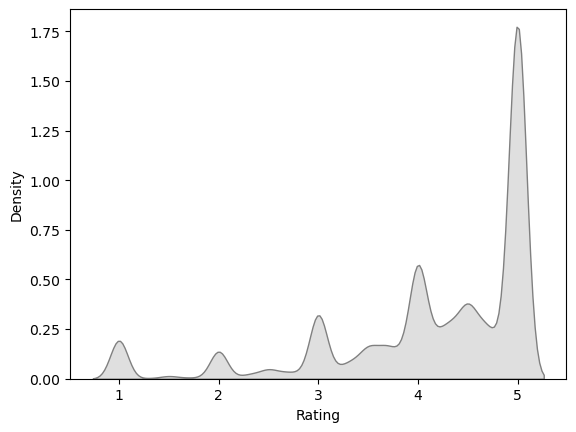

In [10]:
# Mean rating KDE distribution
sns.kdeplot(product_rating, shade=True, color='grey')
plt.show()

We can notice a large spike in the mean rating at value 5. This is a valuable indicator
that points to the skewness of the data. Hence we need to further analyse this issue.

In [11]:
# Count of the number of ratings per Product
product_rating_count = df.groupby('ProductId')['Rating'].count()
product_rating_count.head()

ProductId
0205616461    1
0558925278    2
0733001998    1
0737104473    1
0762451459    1
Name: Rating, dtype: int64

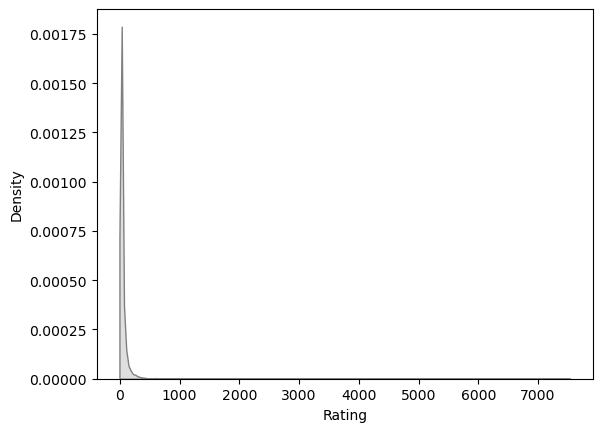

In [12]:
# Number of ratings per product KDE distribution
sns.kdeplot(product_rating_count, shade=True, color='grey')
plt.show()

This graphs confirms the expectation that most items have around 50 - 100 ratings. We do have a bunch of outliers that have only a single rating and few Products have over 2000 ratings.

In [13]:
# Un-Reliability factor
unreliability = df.groupby('ProductId')['Rating'].std(ddof = -1)
unreliability.head()

ProductId
0205616461    0.000000
0558925278    0.816497
0733001998    0.000000
0737104473    0.000000
0762451459    0.000000
Name: Rating, dtype: float64

<Axes: xlabel='Rating', ylabel='Density'>

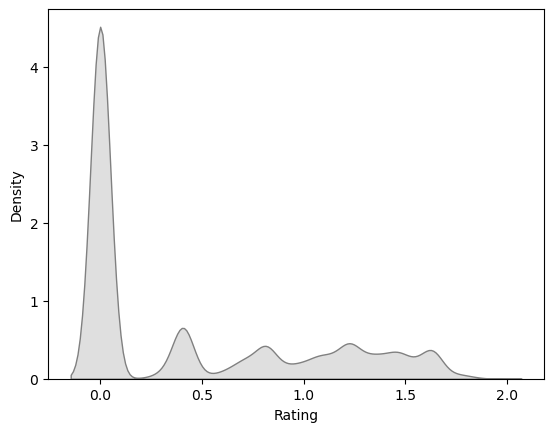

In [14]:
# Un-Reliability factor KDE distribution
sns.kdeplot(unreliability, shade=True, color='grey')

The plot show that a large portion of the products are highly reliable. For this unreliabilit factor we used standard devaiation. But we noticed above that a large porition of the Products have a single review. These items have varying ratings but high reliability. This issue needs to tbe addressed.

### Data transforming
<hr style="height:2px;border-width:0;color:black;background-color:black">
Creating Creating a final collection of all the various measures and features for each product

In [18]:
# Data frame with calculated fields and measures

unique_products_list = df.ProductId.unique()
data_model = pd.DataFrame({'Rating': product_rating[unique_products_list],\
                           'Count': product_rating_count[unique_products_list], \
                          'Unreliability': unreliability[unique_products_list]})
data_model.head()

,Rating,Count,Unreliability
ProductId,,,
0205616461,5.0,1,0.000000
0558925278,4.0,2,0.816497
0733001998,4.0,1,0.000000
0737104473,1.0,1,0.000000
0762451459,5.0,1,0.000000


Let's explore the data model

In [19]:
print("Data model shape (number of data points): %s" % str(data_model.shape))

Data model shape (number of data points): (249274, 3)


<Axes: xlabel='Rating', ylabel='Count'>

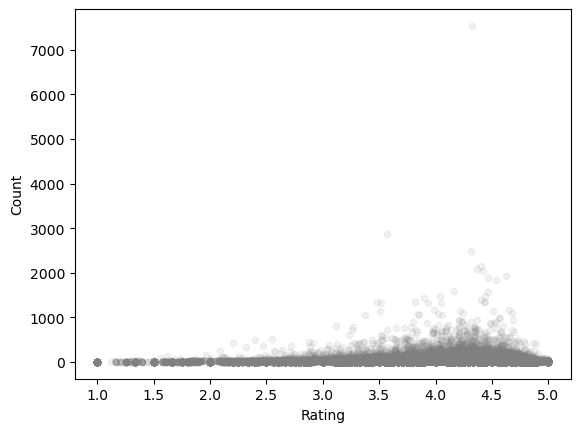

In [20]:
# Rating versus count
data_model.plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.1)

This plot fails to provide much information due to the large number of data points leading to clustered data. So let's break it down into a number of ranges

<Axes: xlabel='Rating', ylabel='Count'>

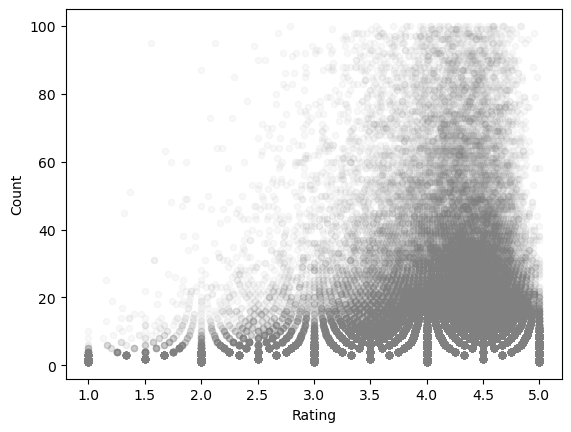

In [21]:
# Less than 100 ratings
data_model[data_model.Count < 101].plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.05)

<Axes: xlabel='Rating', ylabel='Count'>

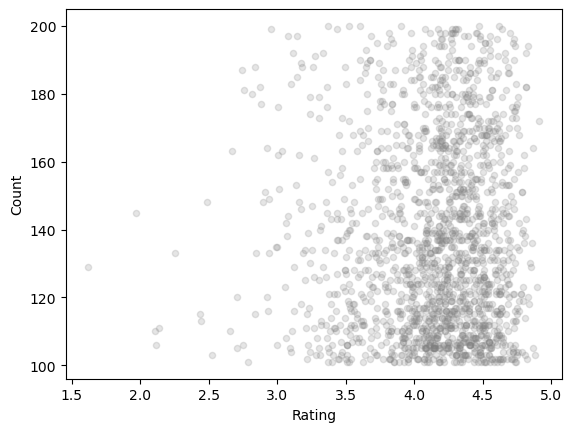

In [22]:
# 100 to 200 ratings
data_model[data_model.Count > 100]\
[data_model.Count<201].plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.2)

<Axes: xlabel='Rating', ylabel='Count'>

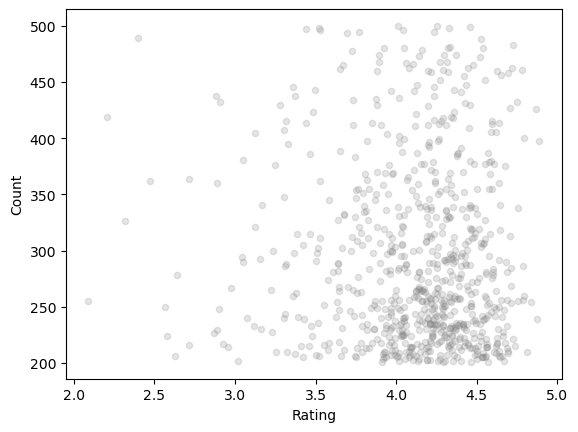

In [23]:
# 200 to 500 ratings
data_model[data_model.Count > 200]\
[data_model.Count<501].plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.2)

We notice that the density becomes sparse as the number of ratings (count) increases. Let's have a look if unreliability has any corelation with the count of ratings and mean rating of the Product.

<Axes: xlabel='Unreliability', ylabel='Count'>

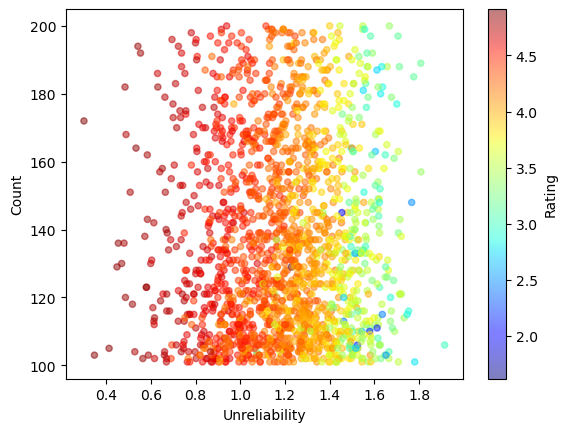

In [25]:
# Adding unreliability factor to the above plots 100 to 200 ratings
data_model[data_model.Count > 100]\
[data_model.Count<201].plot(kind='scatter', x='Unreliability', y='Count', c='Rating', cmap='jet', alpha=0.5)

<Axes: xlabel='Unreliability', ylabel='Count'>

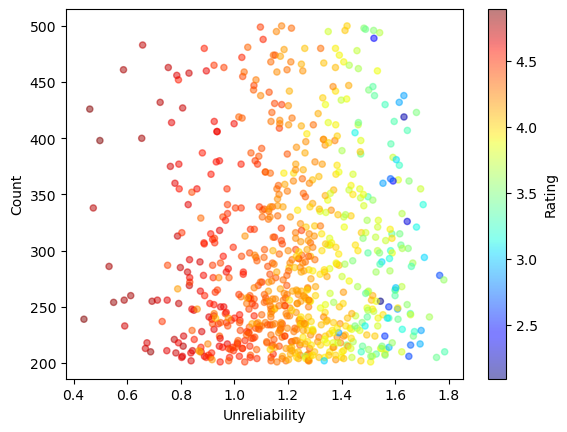

In [26]:
# Addding unreliability factor to the above plots 200 to 500 ratings
data_model[data_model.Count > 200]\
[data_model.Count<501].plot(kind='scatter', x='Unreliability', y='Count', c='Rating', cmap='jet', alpha=0.5)

Wow! Here we see a trend. It looks like those which have a high unreliability score, seem to have a lower rating over a significant count range. Let's see if there is an corelation between these factors.

In [27]:
# Coefficient of corelation between Unreliability and Rating

coeff_corelation = np.corrcoef(x=data_model.Unreliability, y=data_model.Rating)
print("Coefficient of corelation: ")
print(coeff_corelation)

Coefficient of corelation: 
[[ 1.         -0.26862182]
 [-0.26862182  1.        ]]


We notice that there is medium-strong negative corelation from the -0.26862181 coefficient. This means that as the unreliability factor increases, there is a medium-strong change that the rating of the product decreases. This is a good indicator as it clarifies any questions regarding unreliability.

### Data modelling
<hr style="height:2px;border-width:0;color:black;background-color:black">
Let's see if we are ready to make prediction. If not we must model the data into an appropriate format.

In [28]:
# Summarize Count
data_model.Count.describe()

count    249274.000000
mean          8.115848
std          36.064113
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max        7533.000000
Name: Count, dtype: float64

In [29]:
# Summarize Rating
data_model.Rating.describe()

count    249274.000000
mean          4.149251
std           1.047265
min           1.000000
25%           3.750000
50%           4.500000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [30]:
# Summarize Unreliability
data_model.Unreliability.describe()

count    249274.000000
mean          0.459072
std           0.582903
min           0.000000
25%           0.000000
50%           0.000000
75%           0.978337
max           1.925233
Name: Unreliability, dtype: float64

It's clear that the count ranges form 1 to 7533 ratings, the Mean rating ranges from 1 to 5 and the Unrelaibility factor ranges form 0 to 1.92. These values cannot be use directly as they have a vastly varying range.

In [31]:
# Removing outliers and improbable data points
data_model = data_model[data_model.Count > 50][data_model.Count < 1001].copy()
print(data_model.shape)

(6763, 3)


In [32]:
# Normalization function to range 0 - 10
def normalize(values):
    mn = values.min()
    mx = values.max()
    return(10.0/(mx - mn) * (values - mx)+10)

In [33]:
data_model_norm = normalize(data_model)
data_model_norm.head()

,Rating,Count,Unreliability
ProductId,,,
9790790961,7.991506,0.201913,6.557281
B00004TMFE,5.713948,0.913921,7.953812
B00004TUBL,8.992153,5.387885,4.449336
B00004TUBV,7.984827,1.275239,6.268773
B00004U9UY,9.244724,1.009564,4.066169


### Recommendation
<hr style="height:2px;border-width:0;color:black;background-color:black">
Once we have modelled the data, we recomending similar items based on Count of ratings, Mean rating and the Unreliability factor

In [34]:
# Setting up the model
# Recommend 20 similar items
engine = KNeighborsClassifier(n_neighbors=20)

# Training data points
data_points = data_model_norm[['Count', 'Rating', 'Unreliability']].values

#Training labels
labels = data_model_norm.index.values

print("Data points: ")
print(data_points)
print("Labels: ")
print(labels)

engine.fit(data_points, labels)

Data points: 
[[0.20191286 7.99150579 6.55728119]
 [0.91392136 5.71394752 7.95381168]
 [5.38788523 8.99215344 4.44933587]
 ...
 [0.21253985 9.6117244  2.18485285]
 [3.04994687 9.33120102 2.47548276]
 [4.64399575 8.69505981 5.78555039]]
Labels: 
['9790790961' 'B00004TMFE' 'B00004TUBL' ... 'B00KWE08Q0' 'B00KWFDBKE'
 'B00L5JHZJO']


KNeighborsClassifier(n_neighbors=20)

Now that the engine is setup and we have initialized it with the required data points and labels, we can use it to recommend a list of 20 similar items

Recommended products: 
[Index(['B00L5JHZJO', 'B00021C1LI', 'B00FAEOCP0', 'B00178TVXG', 'B000ZLVUYO',
       'B008O4YM4Y', 'B000L9YYTS', 'B001MWV40U', 'B000F63TW0', 'B000OQ2DL4',
       'B001330XFA', 'B001HTYJLO', 'B000TAE0RK', 'B0023A7JF4', 'B001TJXI5U',
       'B008RVYJS8', 'B0008IV7BU', 'B001C6H6F8', 'B000G33KEO', 'B000GHWSG6'],
      dtype='object', name='ProductId')]


<Axes: xlabel='Rating', ylabel='Unreliability'>

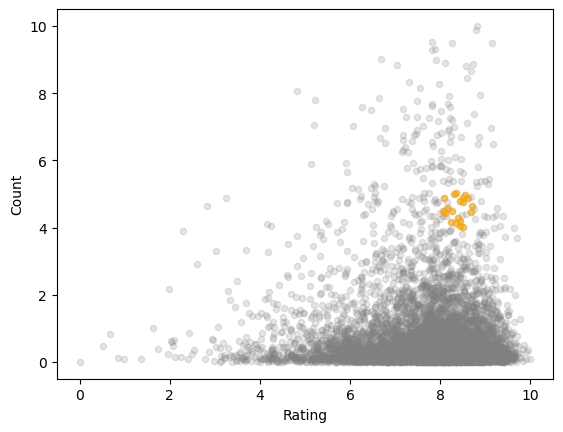

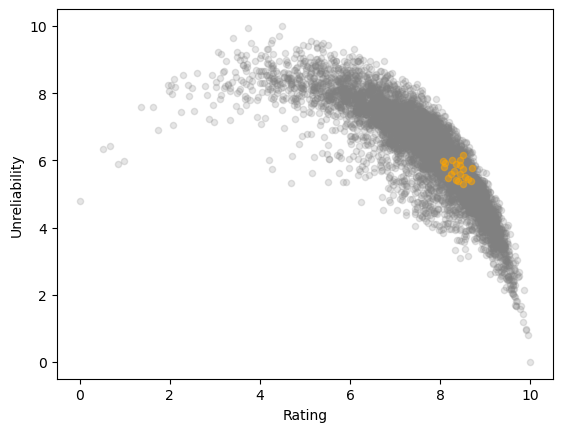

In [35]:
# Enter product ID to get a list of 20 recommended items
# User entered value
product_id = 'B00L5JHZJO'

product_data = [data_model_norm.loc[product_id][['Count', 'Rating', 'Unreliability']].values]

recommended_products = engine.kneighbors(X=product_data, n_neighbors=20, return_distance=False)

# List of product IDs form the indexes
products_list = []

for each in recommended_products:
    products_list.append(data_model_norm.iloc[each].index)

print("Recommended products: ")
print(products_list)

# Showing recommended products
ax = data_model_norm.plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.20)
data_model_norm.iloc[recommended_products[0]].plot(kind='scatter', x='Rating', y='Count',\
                                                   color='orange', alpha=0.5, ax=ax)

ax2 = data_model_norm.plot(kind='scatter', x='Rating', y='Unreliability', color='grey', alpha=0.20)
data_model_norm.iloc[recommended_products[0]].plot(kind='scatter', x='Rating', y='Unreliability',\
                                                   color='orange', alpha=0.5, ax=ax2)

### Conclusion
<hr style="height:2px;border-width:0;color:black;background-color:black">
The engine recommends similar products based on feature such as number of ratings, mean ratings and unreliability factor of the Product. As seen from the above output, we can alter the number of items recommended, and using this we can integrate onine sale trends into retails stores by recommending similar products to the store. This also can be used as an added feature as a plus point when discussing item sales and profits with the stores.